## AI-Based Early Detection of Diabetic Retinopathy Using Retinal Fundus

Import necessary library 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from skimage.io import imread
import os
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetB0, ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,  auc, ConfusionMatrixDisplay

from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
import albumentations as A
from tensorflow.keras.utils import to_categorical

Reading the csv format for the images

In [2]:
test = pd.read_csv('../Final_projec/aptos2019-blindness-detection/test.csv')
train = pd.read_csv('../Final_projec/aptos2019-blindness-detection/train.csv')

Displaying training and test images

In [3]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


Copying the entire training set and converting the classification from 5 to 3 

In [4]:
train_modified = train.copy()

In [5]:
train_modified['diagnosis'] = train_modified['diagnosis'].apply(lambda x: 1 if x in [1, 2]
                                                                else (2 if x in [3, 4]
                                                                else 0))

Displaying the 3 different classses according to diagnosis

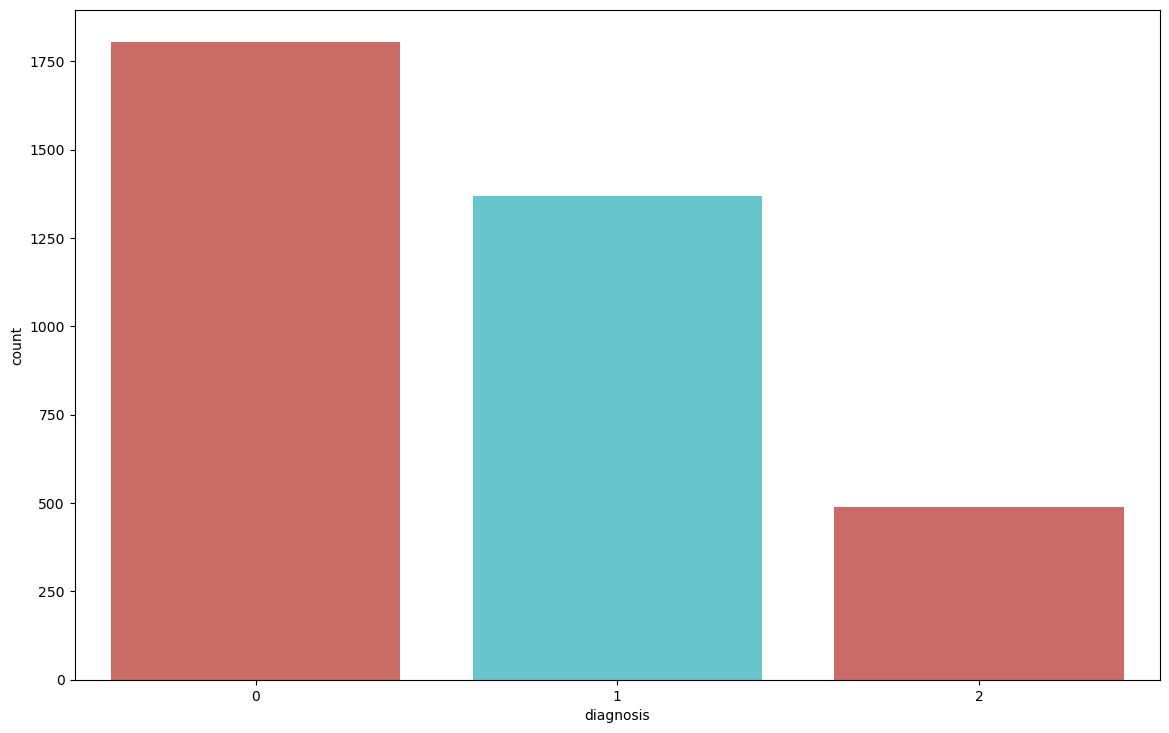

In [7]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x='diagnosis', hue='diagnosis', data=train_modified, palette="hls", legend=False)
plt.show()

Displaying first 15 images of the dataset

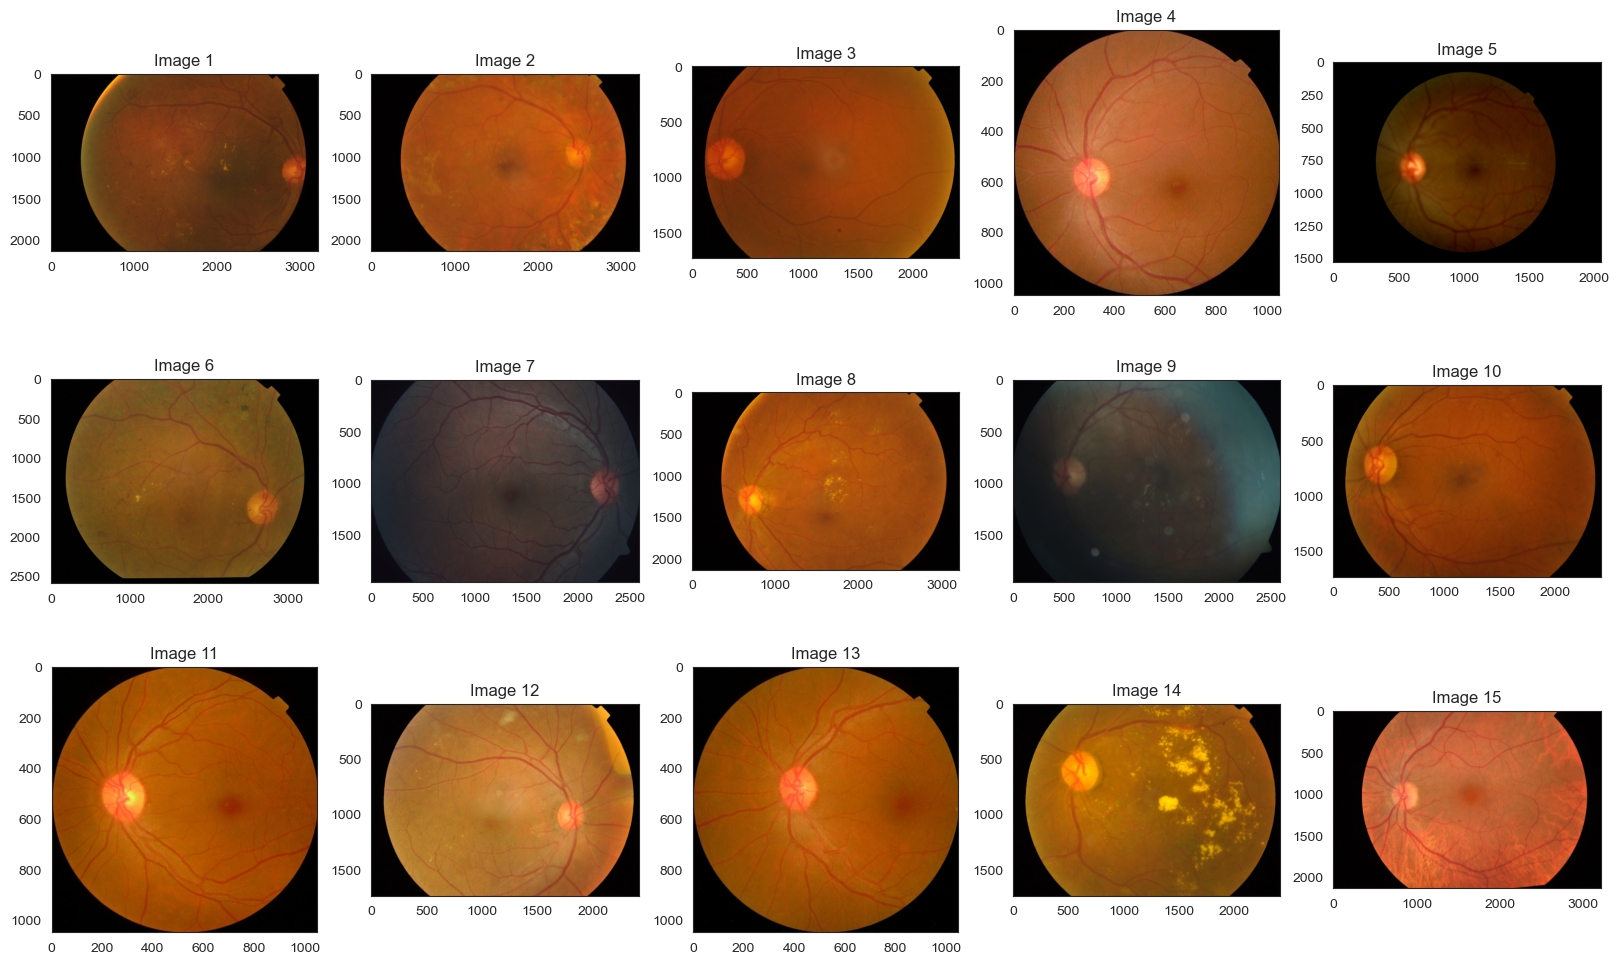

In [8]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img = cv2.imread("../Final_projec/aptos2019-blindness-detection/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [11]:
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv('../Final_projec/aptos2019-blindness-detection/train.csv')
train_df['id_code'] = train_df['id_code'] + ".png"

train_df['diagnosis'] = train_df['diagnosis'].apply(lambda x: 1 if x in [1, 2]
                                                    else (2 if x in [3, 4]
                                                    else 0))

print(f"Training images: {train_df.shape[0]}")
display(train_df.head())

print("Image IDs (TEST)")
test_df = pd.read_csv('../Final_projec/aptos2019-blindness-detection/test.csv')
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())


Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,1
1,001639a390f0.png,2
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


Displaying images of 3 diagnosis classes 

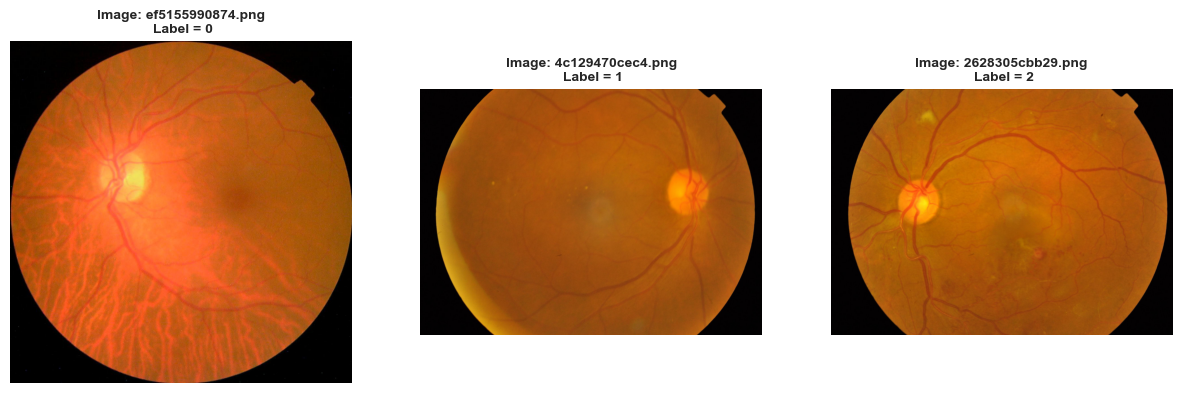

In [15]:
TRAIN_IMG_PATH = '../Final_projec/aptos2019-blindness-detection/' + "train_images/"
SEED = 42
fig, ax = plt.subplots(1,3,figsize = (15,5))
for i in range(3):
    sample = train_df[train_df.diagnosis == i].sample(1,random_state=SEED)
    image_name = sample['id_code'].item()
    X = cv2.cvtColor(cv2.imread(f'{TRAIN_IMG_PATH}{image_name}'), cv2.COLOR_BGR2RGB)
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X)

Defining function for image pre-processing

In [26]:
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge((l_eq, a, b))
    return cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)

def apply_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.bitwise_and(image, image, mask=thresh)

def apply_gamma_correction(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

Defining function for loading and pre-processing images

In [27]:
def load_and_preprocess_image(image_id):
    image = cv2.imread(f'{TRAIN_IMG_PATH}{image_id}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    image = apply_clahe(image)
    image = apply_segmentation(image)
    image = apply_gamma_correction(image)
    
    augmentations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Affine(scale=(0.95, 1.05), translate_percent=(-0.05, 0.05), rotate=(-15, 15), p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3) 
    ])
    
    augmented = augmentations(image=image)
    image = augmented['image'] / 255.0  

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std
    
    return image

Splitting the set into train and validation set

In [28]:
X = train_df['id_code'].values  # Only the image IDs
y = pd.get_dummies(train_df['diagnosis']).values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [29]:
X_train_processed = np.array([load_and_preprocess_image(img) for img in X_train])
X_val_processed = np.array([load_and_preprocess_image(img) for img in X_val])

/var/folders/5w/x0d0ydvs65d_b5ddbmbffwjm0000gn/T/ipykernel_64138/2002300080.py:18: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3)


Defining a function for CNN model

In [30]:
def build_model(base_model, input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)
    x = base_model(include_top=False, weights='imagenet', input_tensor=inputs)
    x = GlobalAveragePooling2D()(x.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
callbacks = [early_stop, reduce_lr]


Training using RESNET50

In [31]:
resnet_model = build_model(ResNet50)
history_resnet = resnet_model.fit(X_train_processed, y_train,
                                  validation_data=(X_val_processed, y_val),
                                  epochs=25, batch_size=32, callbacks=callbacks)


Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 432s 5s/step - accuracy: 0.6845 - loss: 0.7903 - val_accuracy: 0.4870 - val_loss: 0.9352 - learning_rate: 1.0000e-04
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 453s 5s/step - accuracy: 0.8454 - loss: 0.3671 - val_accuracy: 0.4106 - val_loss: 1.3427 - learning_rate: 1.0000e-04
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 450s 5s/step - accuracy: 0.8822 - loss: 0.2940 - val_accuracy: 0.5935 - val_loss: 0.8673 - learning_rate: 1.0000e-04
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 456s 5s/step - accuracy: 0.9297 - loss: 0.1822 - val_accuracy: 0.6535 - val_loss: 0.7896 - learning_rate: 1.0000e-04
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 465s 5s/step - accuracy: 0.9364 - loss: 0.1643 - val_accuracy: 0.7858 - val_loss: 0.7450 - learning_rate: 1.0000e-04
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 504s 5s/step - accuracy: 0.9582 - loss: 0.1212 - val_accuracy: 0.7190 - val_loss: 0.9307 - learning_rate: 1.0000e-04
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 530s 6s/step - accuracy: 0.9713 

Training using VGG19

In [35]:
vgg_model = build_model(VGG19)
history_vgg = vgg_model.fit(X_train_processed, y_train,
                            validation_data=(X_val_processed, y_val),
                            epochs=25, batch_size=32, callbacks=callbacks)

Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1302s 14s/step - accuracy: 0.5664 - loss: 0.9654 - val_accuracy: 0.7790 - val_loss: 0.5974 - learning_rate: 1.0000e-04
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1383s 15s/step - accuracy: 0.7462 - loss: 0.6189 - val_accuracy: 0.7858 - val_loss: 0.5836 - learning_rate: 1.0000e-04
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1512s 16s/step - accuracy: 0.7925 - loss: 0.5417 - val_accuracy: 0.7981 - val_loss: 0.5384 - learning_rate: 1.0000e-04
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1521s 17s/step - accuracy: 0.8008 - loss: 0.5288 - val_accuracy: 0.8254 - val_loss: 0.4699 - learning_rate: 1.0000e-04
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1425s 15s/step - accuracy: 0.8112 - loss: 0.5051 - val_accuracy: 0.8022 - val_loss: 0.5435 - learning_rate: 1.0000e-04
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1395s 15s/step - accuracy: 0.8090 - loss: 0.4725 - val_accuracy: 0.8186 - val_loss: 0.4301 - learning_rate: 1.0000e-04
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1415s 15s/step - acc

Training using InceptionV3 model

In [36]:
inception_model = build_model(InceptionV3)
history_inception = inception_model.fit(X_train_processed, y_train,
                                        validation_data=(X_val_processed, y_val),
                                        epochs=25, batch_size=32, callbacks=callbacks)


Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.6498 - loss: 0.8046 - val_accuracy: 0.8008 - val_loss: 0.5594 - learning_rate: 1.0000e-04
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.8330 - loss: 0.3854 - val_accuracy: 0.8186 - val_loss: 0.5490 - learning_rate: 1.0000e-04
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8857 - loss: 0.2987 - val_accuracy: 0.8145 - val_loss: 0.5740 - learning_rate: 1.0000e-04
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.9231 - loss: 0.2091 - val_accuracy: 0.8172 - val_loss: 0.6374 - learning_rate: 1.0000e-04
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.9393 - loss: 0.1687 - val_accuracy: 0.8063 - val_loss: 0.5845 - learning_rate: 1.0000e-04
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.9794 - loss: 0.0642 - val_accuracy: 0.8240 - val_loss: 0.5865 - learning_rate: 2.0000e-05
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.9910 

Evaluation of the model for results

In [37]:
def evaluate_model(model, X_val, y_val, model_name='Model'):
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1 = report['macro avg']['f1-score']
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    roc_auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovr')

    print(f'\n--- {model_name} Evaluation ---')
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("ROC AUC Score (macro):", roc_auc)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'ROC_AUC_Macro': roc_auc,
        'F1_Score': f1,
        'Precision': precision,
        'Recall': recall
    }


In [38]:
results = []
results.append(evaluate_model(vgg_model, X_val_processed, y_val, 'VGG19'))
results.append(evaluate_model(inception_model, X_val_processed, y_val, 'InceptionV3'))
results.append(evaluate_model(resnet_model, X_val_processed, y_val, 'ResNet50'))


23/23 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step

--- VGG19 Evaluation ---
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       361
           1       0.71      0.91      0.80       275
           2       0.50      0.03      0.06        97

    accuracy                           0.82       733
   macro avg       0.71      0.63      0.60       733
weighted avg       0.79      0.82      0.77       733

Confusion Matrix:
[[348  13   0]
 [ 22 250   3]
 [  4  90   3]]
ROC AUC Score (macro): 0.9215193195210242
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 684ms/step

--- InceptionV3 Evaluation ---
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       361
           1       0.70      0.91      0.79       275
           2       0.65      0.15      0.25        97

    accuracy                           0.82       733
   macro avg       0.77      0.66      0.66       733
weighted avg       0.82      0.82      0.79     

In [43]:
pred_vgg = vgg_model.predict(X_val_processed)
pred_incep = inception_model.predict(X_val_processed)
pred_resnet = resnet_model.predict(X_val_processed)

23/23 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 548ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 829ms/step


Ensemble model: VGG19 + InceptionV3

In [44]:
# Ensemble: VGG19 + InceptionV3
ensemble_soft_voting_2 = (pred_vgg + pred_incep) / 2
y_pred_ens2 = np.argmax(ensemble_soft_voting_2, axis=1)
y_true = np.argmax(y_val, axis=1)

report2 = classification_report(y_true, y_pred_ens2, output_dict=True)
acc_ensemble2 = report2['accuracy']
f1_ensemble2 = report2['macro avg']['f1-score']
prec_ensemble2 = report2['macro avg']['precision']
recall_ensemble2 = report2['macro avg']['recall']
auc_ensemble2 = roc_auc_score(y_val, ensemble_soft_voting_2, multi_class='ovr')

results.append({
    'Model': 'Ensemble (VGG+Incep)',
    'Accuracy': acc_ensemble2,
    'ROC_AUC_Macro': auc_ensemble2,
    'F1_Score': f1_ensemble2,
    'Precision': prec_ensemble2,
    'Recall': recall_ensemble2
})


Ensemble model: VGG19 + InceptionV3 + ResNet50

In [45]:
# Ensemble: VGG19 + InceptionV3 + ResNet50
ensemble_soft_voting_3 = (pred_vgg + pred_incep + pred_resnet) / 3
y_pred_ens3 = np.argmax(ensemble_soft_voting_3, axis=1)

report3 = classification_report(y_true, y_pred_ens3, output_dict=True)
acc_ensemble3 = report3['accuracy']
f1_ensemble3 = report3['macro avg']['f1-score']
prec_ensemble3 = report3['macro avg']['precision']
recall_ensemble3 = report3['macro avg']['recall']
auc_ensemble3 = roc_auc_score(y_val, ensemble_soft_voting_3, multi_class='ovr')

results.append({
    'Model': 'Ensemble (All 3)',
    'Accuracy': acc_ensemble3,
    'ROC_AUC_Macro': auc_ensemble3,
    'F1_Score': f1_ensemble3,
    'Precision': prec_ensemble3,
    'Recall': recall_ensemble3
})

Summary of all the models(Results)

In [64]:
summary_df = pd.DataFrame(results)
summary_df

,Model,Accuracy,ROC_AUC_Macro,F1_Score,Precision,Recall
0,VGG19,0.819918,0.921519,0.600457,0.712899,0.634669
1,InceptionV3,0.818554,0.910107,0.659819,0.766916,0.663903
2,ResNet50,0.844475,0.940007,0.766987,0.791956,0.753576
3,Ensemble (VGG+Incep),0.826739,0.926207,0.627599,0.784081,0.649916
4,Ensemble (VGG+Incep),0.826739,0.926207,0.627599,0.784081,0.649916
5,Ensemble (All 3),0.839018,0.939252,0.709438,0.808950,0.699504


Defining functions for ROC AUC curve and Confusion matrix

In [47]:
def plot_roc_auc(y_true, y_probs, model_name):
    n_classes = y_probs.shape[1]
    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [48]:
def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.grid(False)
    plt.show()


92/92 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step


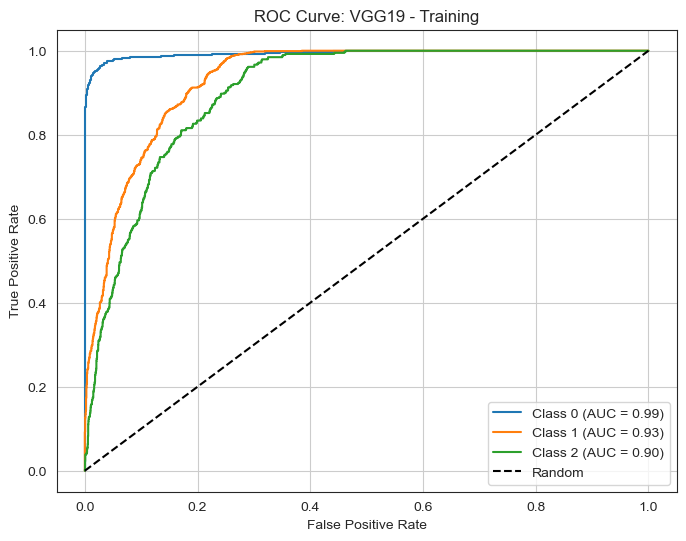

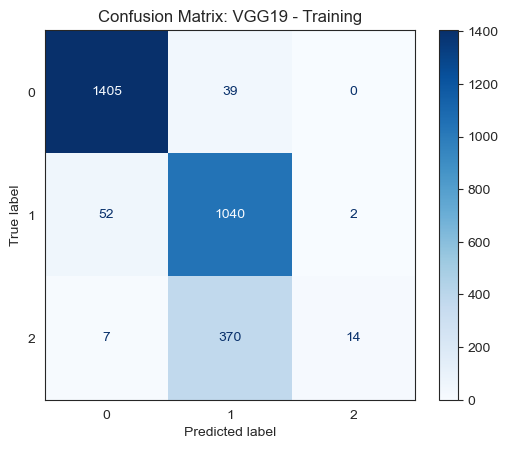

In [56]:
y_probs_train_vgg = vgg_model.predict(X_train_processed)
y_pred_train_vgg = np.argmax(y_probs_train_vgg, axis=1)
y_true_train = np.argmax(y_train, axis=1)

plot_roc_auc(y_train, y_probs_train_vgg, 'VGG19 - Training')
plot_conf_matrix(y_true_train, y_pred_train_vgg, 'VGG19 - Training')

23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step


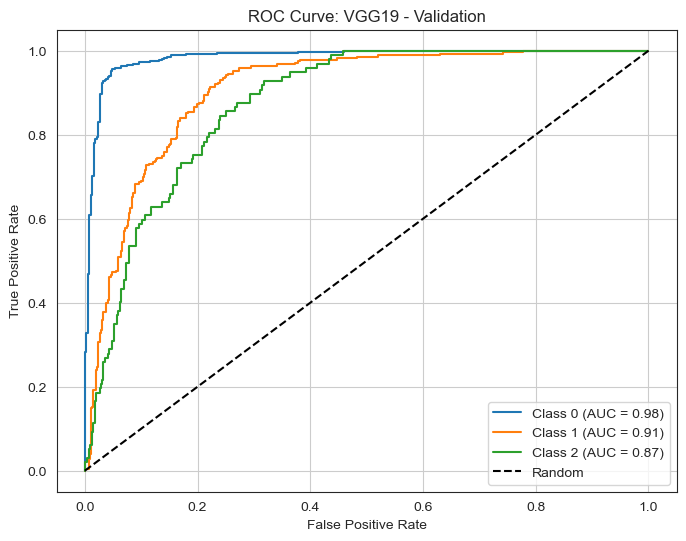

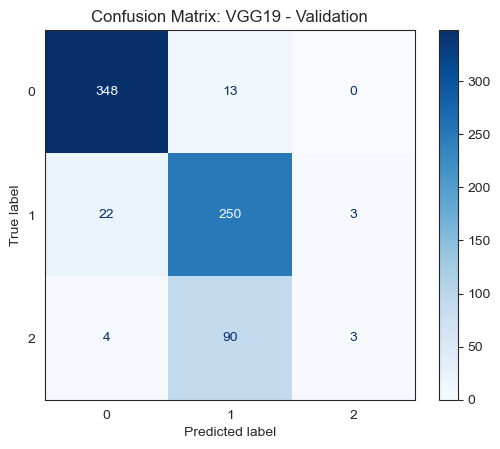

In [57]:
y_probs_vgg = vgg_model.predict(X_val_processed)
y_pred_vgg = np.argmax(y_probs_vgg, axis=1)
y_true = np.argmax(y_val, axis=1)

plot_roc_auc(y_val, y_probs_vgg, 'VGG19 - Validation')
plot_conf_matrix(y_true, y_pred_vgg, 'VGG19 - Validation')


92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 533ms/step


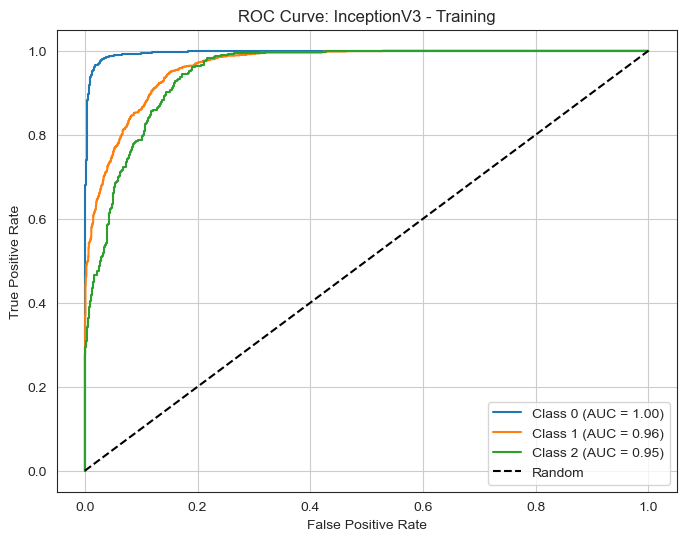

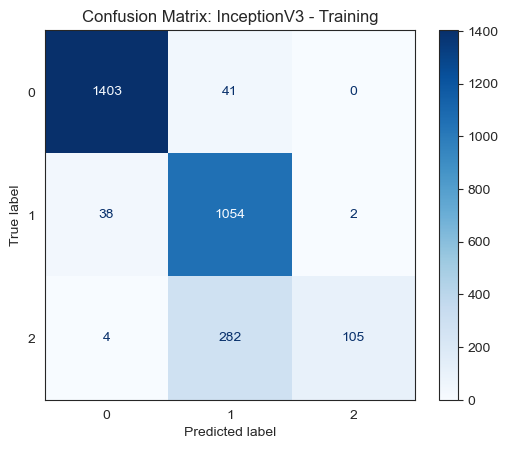

In [58]:
y_probs_train_incep = inception_model.predict(X_train_processed)
y_pred_train_incep = np.argmax(y_probs_train_incep, axis=1)
y_true_train = np.argmax(y_train, axis=1)

plot_roc_auc(y_train, y_probs_train_incep, 'InceptionV3 - Training')
plot_conf_matrix(y_true_train, y_pred_train_incep, 'InceptionV3 - Training')

23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 582ms/step


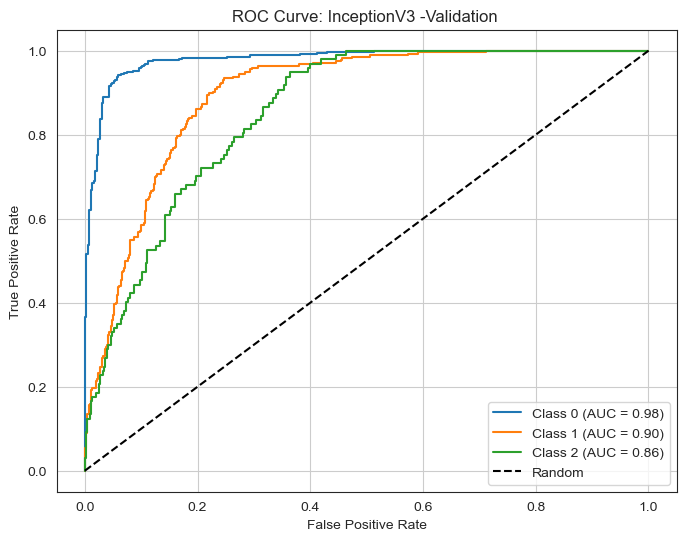

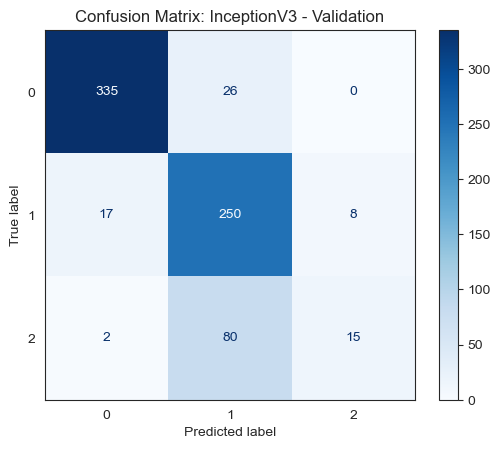

In [59]:
y_probs_incep = inception_model.predict(X_val_processed)
y_pred_incep = np.argmax(y_probs_incep, axis=1)

plot_roc_auc(y_val, y_probs_incep, 'InceptionV3 -Validation ')
plot_conf_matrix(y_true, y_pred_incep, 'InceptionV3 - Validation')


92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 933ms/step


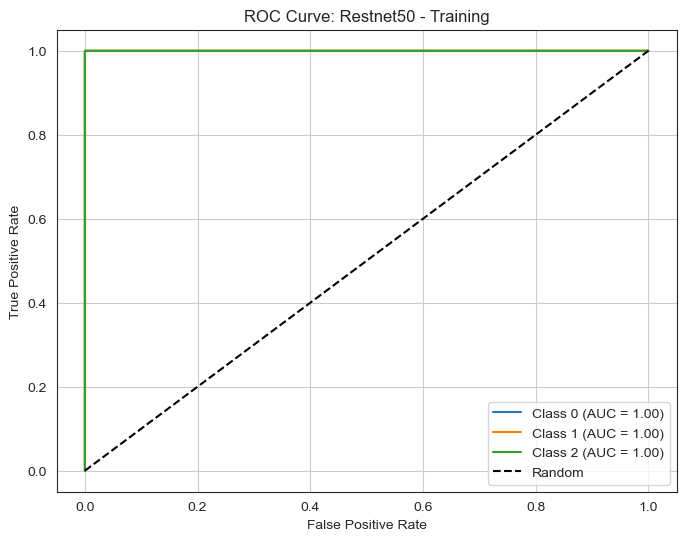

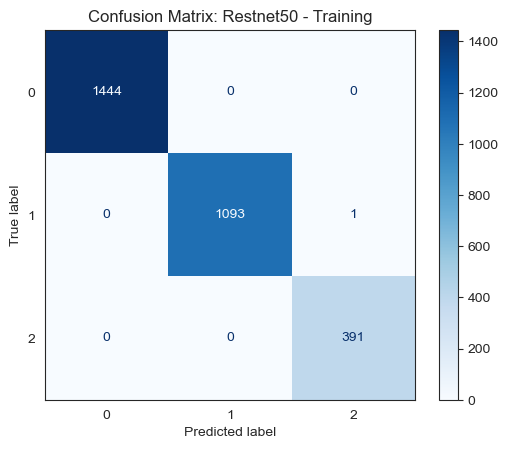

In [60]:
y_probs_train_resnet = resnet_model.predict(X_train_processed)
y_pred_train_resnet = np.argmax(y_probs_train_resnet, axis=1)
y_true_train = np.argmax(y_train, axis=1)

plot_roc_auc(y_train, y_probs_train_resnet, 'Restnet50 - Training')
plot_conf_matrix(y_true_train, y_pred_train_resnet, 'Restnet50 - Training')

23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


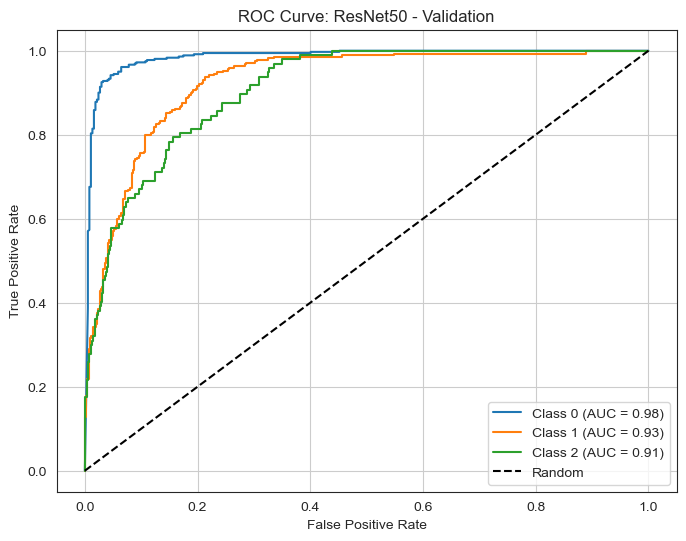

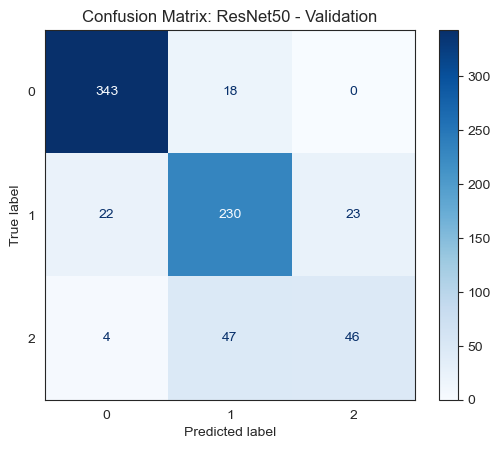

In [61]:
y_probs_resnet = resnet_model.predict(X_val_processed)
y_pred_resnet = np.argmax(y_probs_resnet, axis=1)

plot_roc_auc(y_val, y_probs_resnet, 'ResNet50 - Validation')
plot_conf_matrix(y_true, y_pred_resnet, 'ResNet50 - Validation')


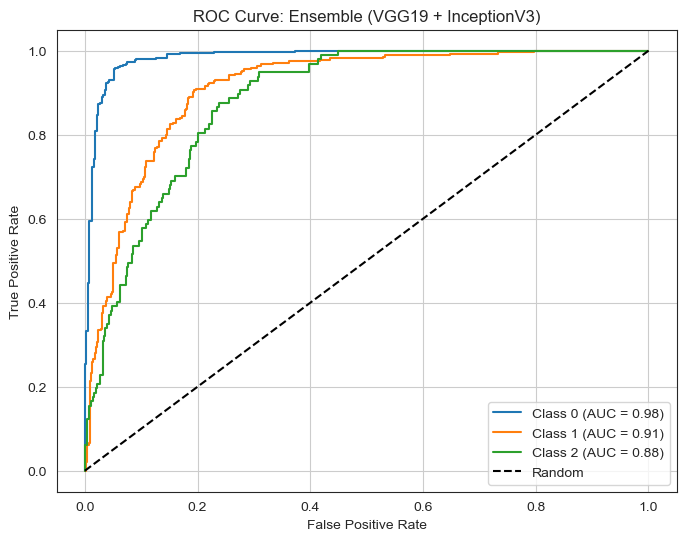

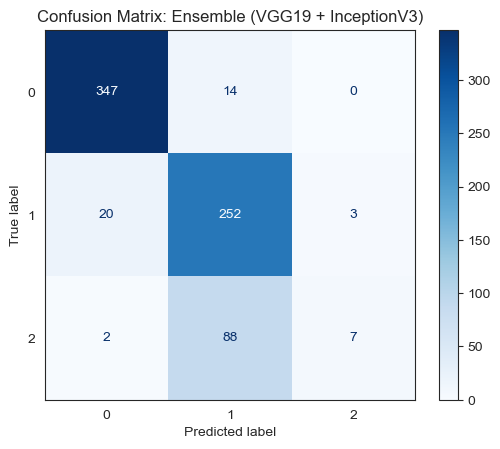

In [51]:
plot_roc_auc(y_val, ensemble_soft_voting_2, 'Ensemble (VGG19 + InceptionV3)')
plot_conf_matrix(y_true, y_pred_ens2, 'Ensemble (VGG19 + InceptionV3)')


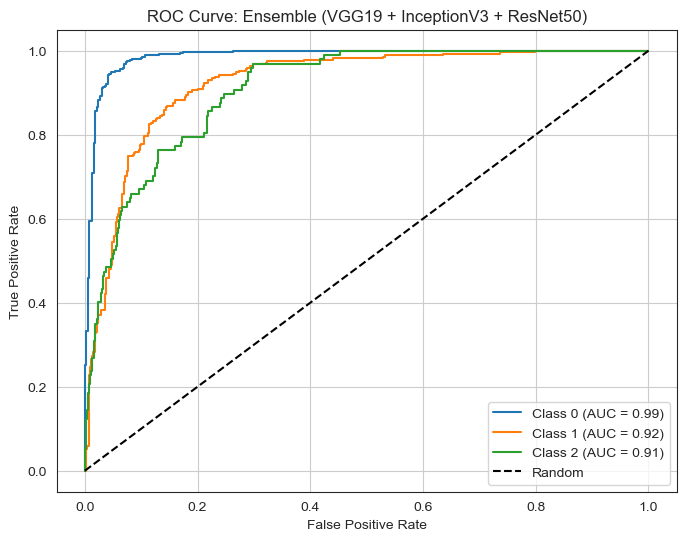

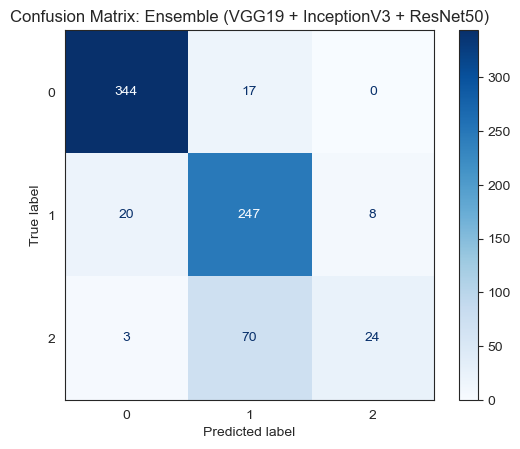

In [52]:
plot_roc_auc(y_val, ensemble_soft_voting_3, 'Ensemble (VGG19 + InceptionV3 + ResNet50)')
plot_conf_matrix(y_true, y_pred_ens3, 'Ensemble (VGG19 + InceptionV3 + ResNet50)')
